# Import libraries and data

In [11]:
# import libraries 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

from matplotlib_venn import venn2
from utils import increase_stringency_CSF, get_uniprot

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
data_path = os.getcwd() + "/Datasets/"
fig_path = os.getcwd() + "/Figures/"

## Feature brain data set

In [4]:
df_features = pd.read_csv(data_path + "/Features/df_features_brain_elevated.csv")
df_features

,Uniprot,Sequence,Length,Molecular weight,A,C,D,E,F,G,...,Glycosylation,GlycoMine_N,GlycoMine_O,GlycoMine_C,GPI-anchor,Signal peptide,RNA_binding,DNA_binding,Ectodomain_shedding,CSF
0,Q99569,MPAPEQASLVEEGQPQTRQEAASTGPGMEPETTATTILASVKEQEL...,1192,131866.7406,0.064597,0.011745,0.046980,0.050336,0.015940,0.061242,...,0.0,0,1,0,0,0,0,0,0,-1
1,Q7L8C5,MVLSVPVIALGATLGTATSILALCGVTCLCRHMHPKKGLLPRDQDP...,426,46884.2716,0.084507,0.025822,0.042254,0.070423,0.014085,0.058685,...,0.0,1,0,0,0,0,0,0,0,-1
2,Q9BT88,MAEITNIRPSFDVSPVVAGLIGASVLVVCVSVTVFVWSCCHQQAEK...,431,48296.3314,0.039443,0.016241,0.064965,0.048724,0.034803,0.060325,...,0.0,1,0,0,0,0,0,0,0,1
3,A0A1B0GUX0,MSRQLNIDALRQNFWKEEYLREKMLRCEWYRKYGSMVKAKQKAKAA...,176,20388.6748,0.079545,0.017045,0.028409,0.056818,0.045455,0.034091,...,0.0,0,0,0,0,0,0,0,0,-1
4,Q5DID0,MLRTSGLALLALVSAVGPSQASGFTEKGLSLLGYQLCSHRVTHTVQ...,1318,144292.2583,0.064492,0.033384,0.036419,0.059939,0.031108,0.072079,...,0.0,1,1,0,0,1,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2537,Q7Z6G3,MCERAARLCRAGAHRLLREPPQQGRALGGLLRWVGARMGEPRESLA...,386,43193.2498,0.093264,0.020725,0.059585,0.088083,0.038860,0.062176,...,0.0,0,0,0,0,0,0,0,0,1
2538,P07196,MSSFSYEPYYSTSYKRRYVETPRVHISSVRSGYSTARSAYSSYSAP...,543,61515.8628,0.110497,0.001842,0.042357,0.182320,0.018416,0.036832,...,0.0,0,0,0,0,0,0,0,0,1
2539,Q9BZQ4,MTETTKTHVILLACGSFNPITKGHIQMFERARDYLHKTGRFIVIGG...,307,34438.2618,0.039088,0.029316,0.058632,0.045603,0.022801,0.061889,...,0.0,0,0,0,0,0,0,0,0,-1
2540,Q96T66,MKSRIPVVLLACGSFNPITNMHLRMFEVARDHLHQTGMYQVIQGII...,252,28321.3452,0.071429,0.011905,0.043651,0.047619,0.019841,0.067460,...,0.0,0,0,0,0,0,0,0,0,-1


In [5]:
df_features["log2(Molecular weight)"] = np.log2(df_features["Molecular weight"])

In [6]:
# # add ectodomain annoation as a feature
# shed = pd.read_csv(data_path + "/Features/Shedding_proteins_UniProt.txt", header=None, names=["Uniprot"])
# df_features["Ectodomain_shedding"] = np.where(df_features["Uniprot"].isin(shed["Uniprot"]), 1, 0)

# shed_DeepSMP = pd.read_csv(data_path + "/Features/Known_shedding_proteins_DeepSMP.txt", sep="\t")
# df_features["Ectodomain_shedding"] = np.where(df_features["Uniprot"].isin(shed_DeepSMP["Uniprot ID"]), 1, 
#     df_features["Ectodomain_shedding"])

## CSF data set

In [7]:
csf = pd.read_csv(data_path + "CSF/csf.csv")

## Create stringent data sets

In [8]:
# create more stringent data sets
df_features_2plus = increase_stringency_CSF(df_features, csf, 2)
print("Number of proteins in dataset:", len(df_features_2plus))
print("-------------")
df_features_3plus = increase_stringency_CSF(df_features, csf, 3)
print("Number of proteins in dataset:", len(df_features_3plus))

Number of CSF proteins to be removed: 303
Number of CSF proteins left: 692
Number of proteins in dataset: 2239
-------------
Number of CSF proteins to be removed: 454
Number of CSF proteins left: 541
Number of proteins in dataset: 2088


In [9]:
non_CSF = df_features[df_features["CSF"] == -1]
CSF_1plus = df_features[df_features["CSF"] == 1]
CSF_2plus = df_features_2plus[df_features_2plus["CSF"] == 1]
CSF_3plus = df_features_3plus[df_features_3plus["CSF"] == 1]

df_list = [non_CSF, CSF_1plus, CSF_2plus, CSF_3plus]
names = ["non-CSF", "CSF", "CSF (2+studies)", "CSF (3+studies)"]

## DeepLoc-1.0 prediction results

In [12]:
deeploc = pd.read_csv(data_path + "Features/DeepLoc_results_human_proteome.txt", sep="\t")
deeploc.rename(columns={"ID":"Uniprot"}, inplace=True)

# retrieve Uniprot ID
deeploc["Uniprot"] = deeploc["Uniprot"].apply(get_uniprot)
deeploc

,Uniprot,Location,Membrane,Nucleus,Cytoplasm,Extracellular,Mitochondrion,Cell_membrane,Endoplasmic_reticulum,Plastid,Golgi_apparatus,Lysosome/Vacuole,Peroxisome
0,Q8WZ42,Cytoplasm,0.0054,0.0528,0.9364,0.0001,0.0000,0.0090,0.0001,0.0001,0.0002,0.0008,0.0006
1,Q8WXI7,Cytoplasm,0.2836,0.1055,0.6656,0.0005,0.0002,0.2102,0.0101,0.0001,0.0041,0.0026,0.0012
2,Q8NF91,Cytoplasm,0.1989,0.0707,0.5495,0.0002,0.0008,0.0319,0.0229,0.0001,0.2861,0.0377,0.0001
3,Q7Z5P9,Extracellular,0.0550,0.0407,0.1452,0.7810,0.0033,0.0277,0.0007,0.0000,0.0002,0.0011,0.0000
4,Q5VST9,Cytoplasm,0.0108,0.0871,0.8976,0.0002,0.0000,0.0140,0.0001,0.0000,0.0002,0.0003,0.0005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20371,P02729,Extracellular,0.0006,0.0031,0.0268,0.9364,0.0315,0.0000,0.0000,0.0022,0.0000,0.0001,0.0000
20372,P0DOY5,Extracellular,0.1216,0.0002,0.0047,0.7318,0.1119,0.0346,0.0005,0.0144,0.0011,0.1006,0.0002
20373,P01858,Extracellular,0.0399,0.2627,0.0592,0.6342,0.0264,0.0119,0.0008,0.0000,0.0047,0.0000,0.0000
20374,P0DPI4,Extracellular,0.3387,0.0396,0.0151,0.4207,0.1285,0.2067,0.0033,0.0027,0.0677,0.1158,0.0000


# Feature Analysis

In [9]:
def get_percentages(df_list, col):
        
    perc_list = []
    for i in range(len(df_list)):
        perc_list.append(sum(df_list[i][col])/len(df_list[i]))

    return perc_list

In [11]:
def plot_percentages(feature_list, file_name, sharey=True):
    """
    """

    fig, ax = plt.subplots(1, len(feature_list), figsize=(5*len(feature_list), 5), sharey=sharey)

    for i in range(len(feature_list)):
        bars = ax[i].bar(x=["non-CSF", "CSF", "CSF (2+studies)", "CSF (3+studies)"], 
            height=get_percentages(df_list, feature_list[i]), color=["darkred", "skyblue", "steelblue", "darkcyan"], 
            edgecolor="black")
        ax[i].bar_label(bars, fmt="%.4f")
        ax[i].tick_params(axis="x", labelrotation=45)
        if i == 0:
            ax[i].set(ylabel="Fraction", title=feature_list[i])
        else:
            ax[i].set(ylabel=None, title=feature_list[i])
    
    plt.show()
    
    fig.savefig(fig_path + file_name, bbox_inches="tight")
    
    return None


def plot_distribution(feature_list, file_name, sharey=True):
    """
    """
    
    # create melted dataframe
    melted = pd.melt(all_coefs, id_vars="index", value_vars=["Mean", "Mean_2_plus", "Mean_3_plus"], var_name="Stringency", 
    value_name="Coefficient")

    fig, ax = plt.subplots(1, len(feature_list), figsize=(5*len(feature_list), 5), sharey=sharey)

    for i in range(len(feature_list)):
        ax[i].violinplot(x=["non-CSF", "CSF", "CSF (2+studies)", "CSF (3+studies)"], 
            height=get_percentages(df_list, feature_list[i]), color=["darkred", "skyblue", "steelblue", "darkcyan"], 
            edgecolor="black")
        ax[i].tick_params(axis="x", labelrotation=45)
        ax[i].set(ylabel=None, title=feature_list[i])

    plt.show()
    
    fig.savefig(fig_path + file_name, bbox_inches="tight")
    
    return None

## Subcellular localization

### Stacked bar plot

In [134]:
non_CSF_loc_counts = pd.DataFrame(non_CSF[["Uniprot"]].merge(deeploc[["Uniprot", "Location"]], 
    on="Uniprot")["Location"].value_counts(normalize=True, dropna=False))
non_CSF_loc_counts.sort_index(inplace=True)

CSF_loc_counts = pd.DataFrame(CSF_1plus[["Uniprot"]].merge(deeploc[["Uniprot", "Location"]], 
    on="Uniprot")["Location"].value_counts(normalize=True, dropna=False))
# CSF_loc_counts = CSF_loc_counts.reindex(deeploc["Location"].unique(), fill_value=0)
CSF_loc_counts.sort_index(inplace=True)

CSF_2plus_loc_counts = pd.DataFrame(CSF_2plus[["Uniprot"]].merge(deeploc[["Uniprot", "Location"]], 
    on="Uniprot")["Location"].value_counts(normalize=True, dropna=False))
CSF_2plus_loc_counts = CSF_2plus_loc_counts.reindex(deeploc["Location"].unique(), fill_value=0)
CSF_2plus_loc_counts.sort_index(inplace=True)

CSF_3plus_loc_counts = pd.DataFrame(CSF_3plus[["Uniprot"]].merge(deeploc[["Uniprot", "Location"]], 
    on="Uniprot")["Location"].value_counts(normalize=True, dropna=False))
CSF_3plus_loc_counts = CSF_3plus_loc_counts.reindex(deeploc["Location"].unique(), fill_value=0)
CSF_3plus_loc_counts.sort_index(inplace=True)

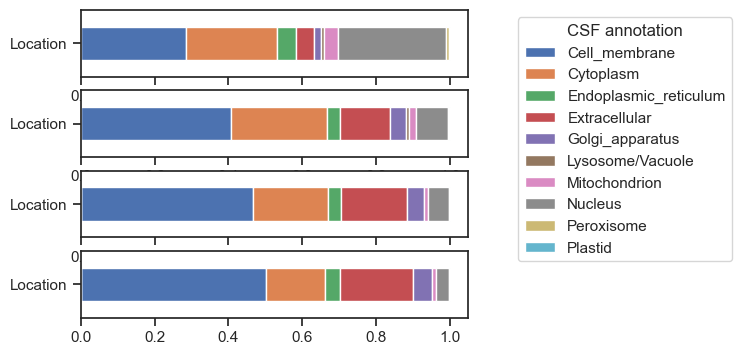

In [136]:
#### TO DO ####
# nicer color mapping an rename in legend
# remove frames

sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(4, 1, figsize=(5, 4))

non_CSF_loc_counts.T.plot.barh(stacked=True, ax=ax[0])
ax[0].legend(title="CSF annotation", loc="upper right", bbox_to_anchor=(1.7, 1))
CSF_loc_counts.T.plot.barh(stacked=True, ax=ax[1])
CSF_2plus_loc_counts.T.plot.barh(stacked=True, ax=ax[2])
CSF_3plus_loc_counts.T.plot.barh(stacked=True, ax=ax[3])

for i in range(1,4):
    ax[i].get_legend().remove()

plt.show()

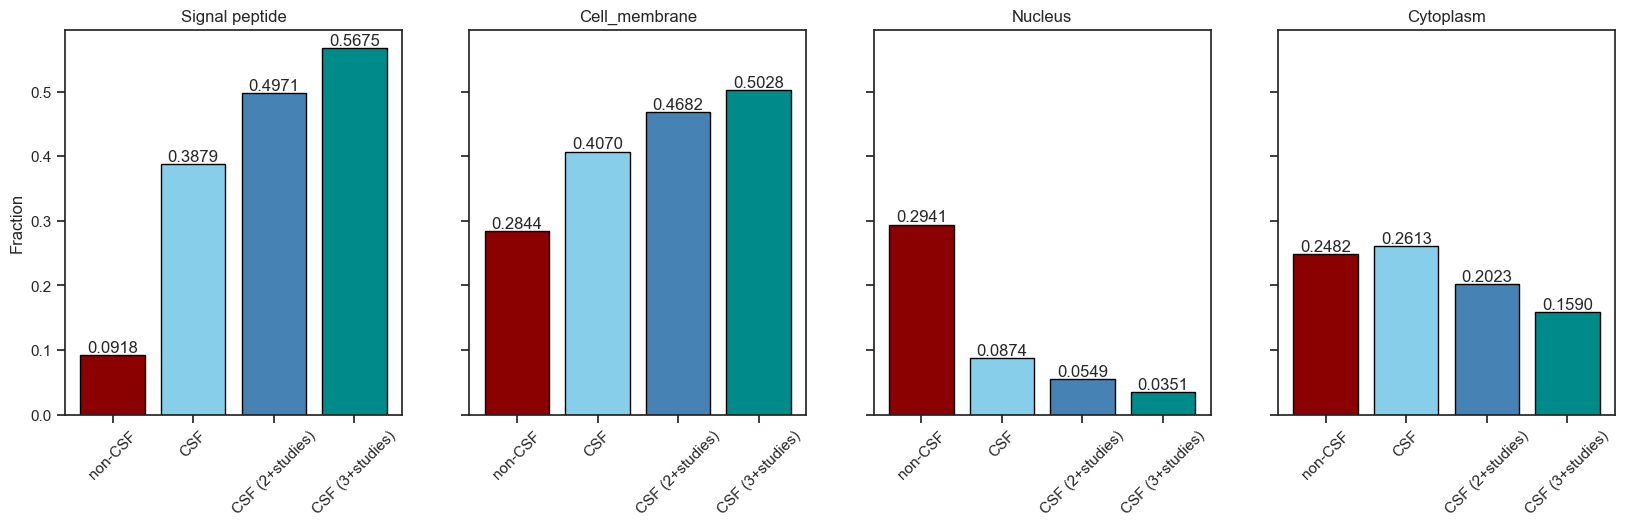

In [80]:
plot_percentages(["Signal peptide", "Cell_membrane", "Nucleus", "Cytoplasm"], "Bar_sucellular_localization_A.png")

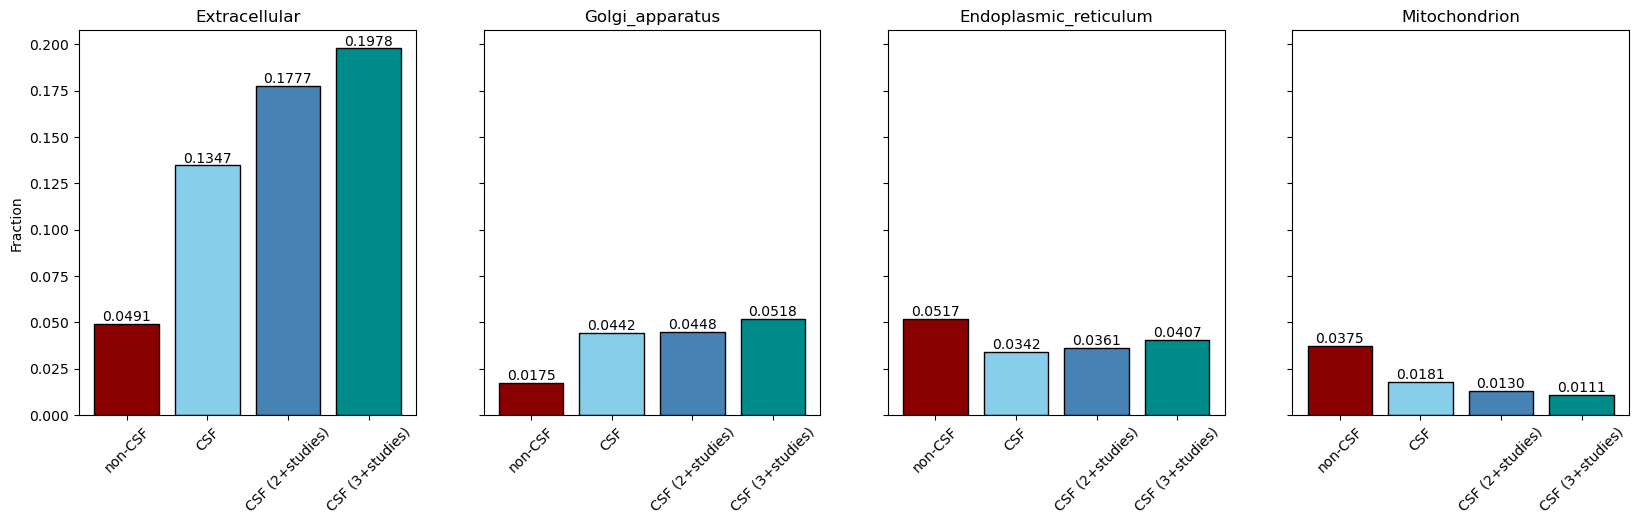

In [46]:
plot_percentages(["Extracellular", "Golgi_apparatus", "Endoplasmic_reticulum", "Mitochondrion"], 
    "Bar_sucellular_localization_B.png")
# "Peroxisome"
# "Lysosome/Vacuole"
# "Plastid"

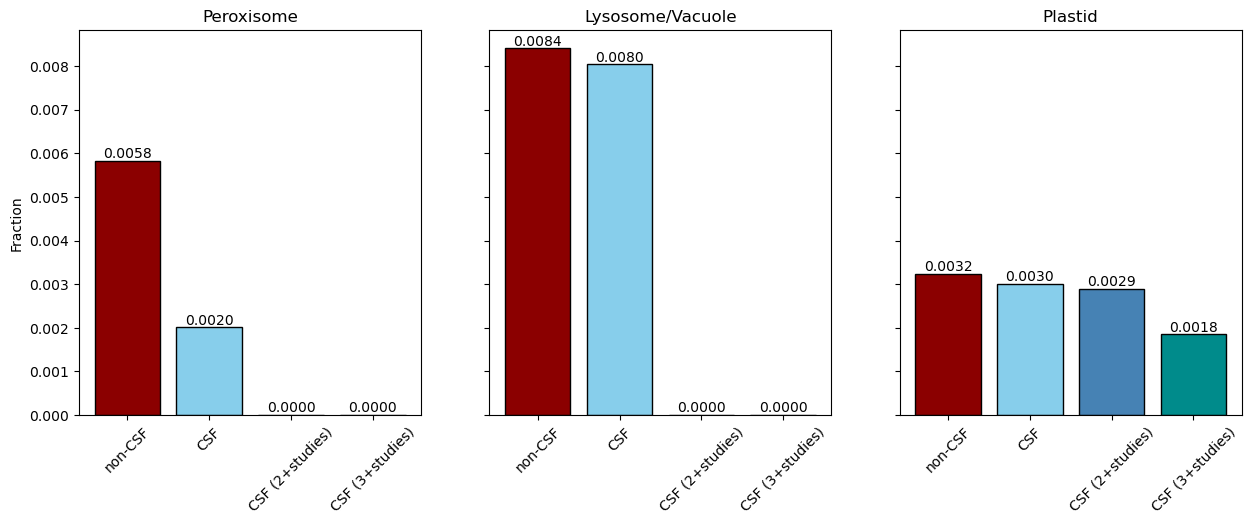

In [47]:
plot_percentages(["Peroxisome", "Lysosome/Vacuole", "Plastid"], 
    "Bar_subcellular_localization_C.png")

## Glycosylation

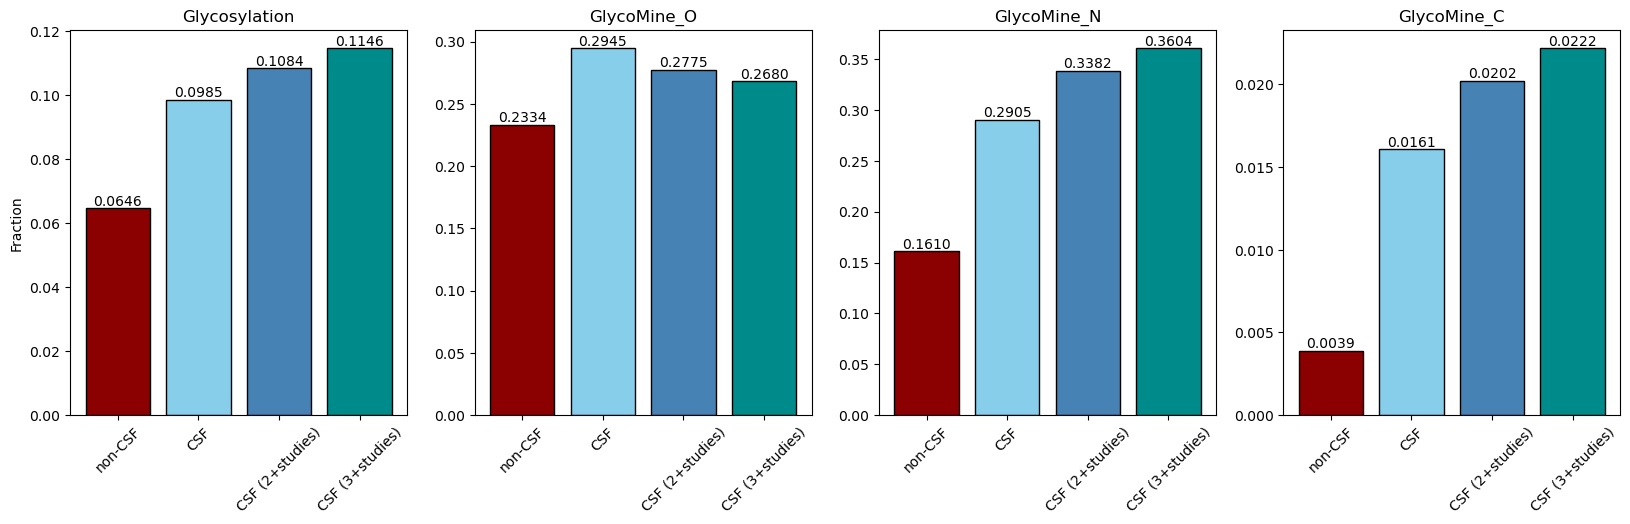

In [48]:
plot_percentages(["Glycosylation", "GlycoMine_O", "GlycoMine_N", "GlycoMine_C"], "Bar_Glycosylation.png", sharey=False)

## Motifs

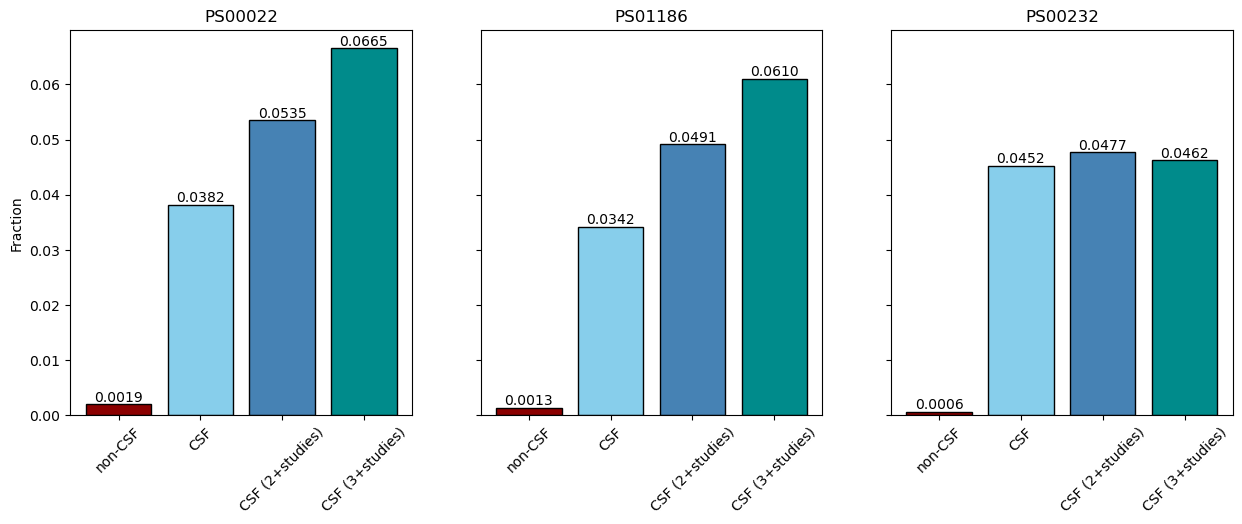

In [49]:
# EGF1 (PS00022)
# EGF2 (PS01186)
# Cadherin-1 (PS00232)
# G-protein receptor F1 (PS00237)
# Homeobox (PS00027)
# Zinc Finger C2H2 (PS00028)

plot_percentages(["PS00022", "PS01186", "PS00232"], "Bar_motifs_A.png")

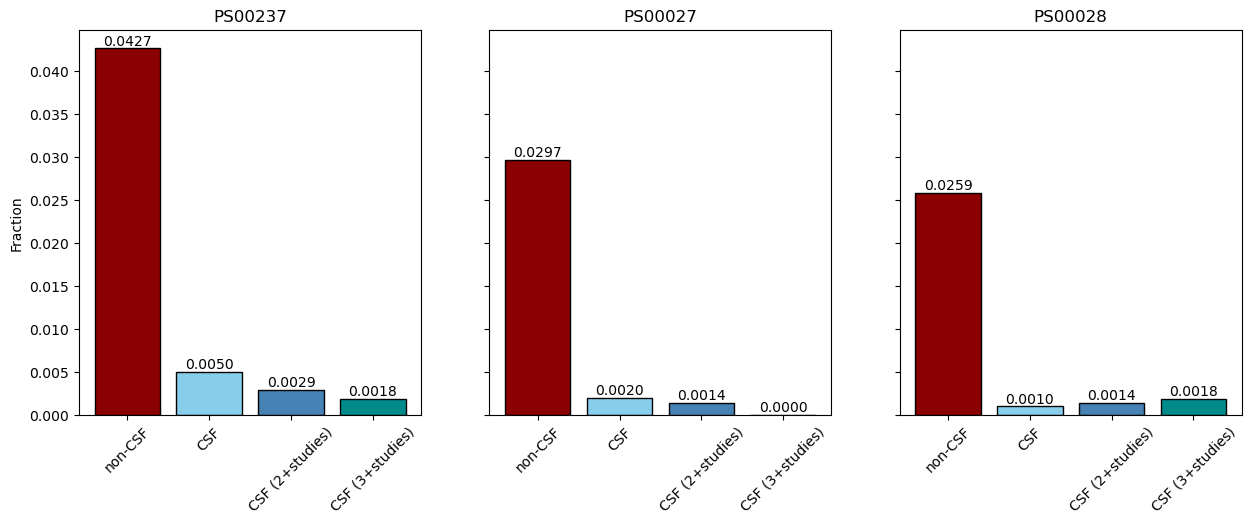

In [50]:
plot_percentages(["PS00237", "PS00027", "PS00028"], "Bar_motifs_B.png")

## Residue binding

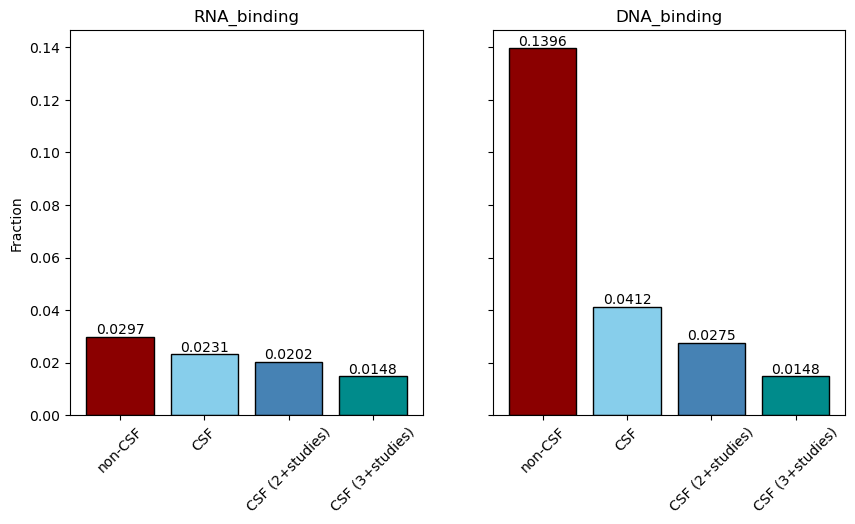

In [51]:
plot_percentages(["RNA_binding", "DNA_binding"], "Bar_residue_binding.png")

## Transmembrane

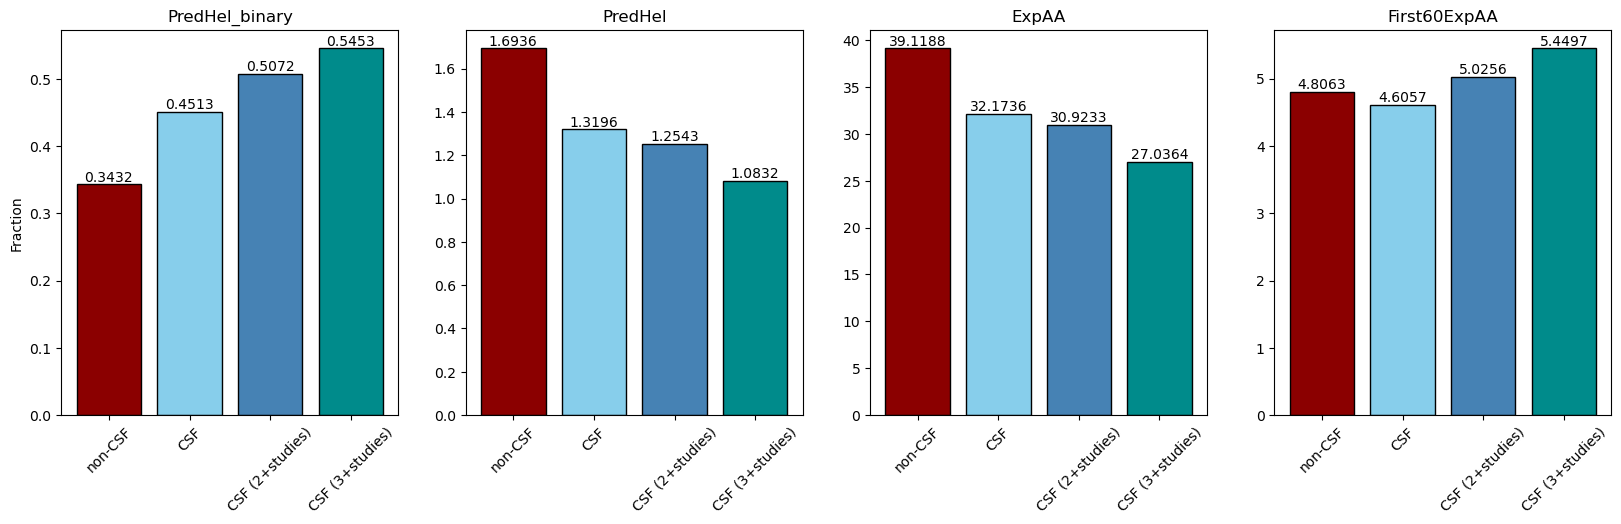

In [52]:
plot_percentages(["PredHel_binary", "PredHel", "ExpAA", "First60ExpAA"], "Bar_transmembrane.png", sharey=False)

In [53]:
# empty dataframe 
tm_df = pd.DataFrame()

for i, data in enumerate(df_list):
    # add proportions of transmembrane region counts to dataframe
    tm = pd.Series(data["PredHel"].value_counts(normalize=True).sort_index(), name=names[i])
    tm_df = pd.merge(tm_df, tm, left_index=True, right_index=True, how="outer")
    
tm_df.reset_index(inplace=True)

In [54]:
# aggregate values of all proteins with >7 predicted transmembrane regions
tm_df_8plus = tm_df[8:].agg([sum])
# add aggregated values to transmembrane dataframe (remove single values for aggregated values)
tm_df = pd.concat([tm_df[:8], tm_df_8plus])
tm_df.loc["sum", "index"] = ">7"

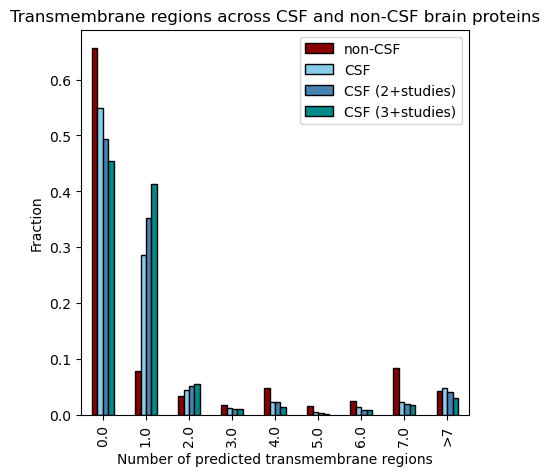

In [55]:
fig, ax = plt.subplots(figsize=(5, 5))

tm_df.plot(x="index", y=["non-CSF", "CSF", "CSF (2+studies)", "CSF (3+studies)"], kind="bar",
          color=["darkred", "skyblue", "steelblue", "darkcyan"], edgecolor="black", ax=ax)
ax.set(xlabel="Number of predicted transmembrane regions", ylabel="Fraction", 
    title="Transmembrane regions across CSF and non-CSF brain proteins")

plt.show()   
fig.savefig(fig_path + "Bar_number_of_transmembrane_regions.png", bbox_inches="tight")

In [56]:
#### TO DO #####
# move this part to feature generation

def count_domains(df):
    
    domains = df["Topological domain"]
    
    df["Cytoplasmic_domain"] = 0
    df["Extracellular_domain"] = 0
    df["Lumenal_domain"] = 0
    df["Vesicular_domain"] = 0
    
    if type(domains) != str:
        return df
    else:
        df["Cytoplasmic_domain"] = domains.count("Cytoplasmic")
        df["Extracellular_domain"] = domains.count("Extracellular")
        df["Lumenal_domain"] = domains.count("Lumenal")
        df["Vesicular_domain"] = domains.count("Vesicular")
        
    return df

In [57]:
tm_info = pd.read_csv(data_path + "Features/Uniprot_topological_domain_transmembrane_human_proteome.tab", sep="\t", header=0, 
    names=["Uniprot", "Topological domain", "Transmembrane"])
# drop entries without information
tm_info.dropna(axis=0, how="all", subset=["Topological domain", "Transmembrane"], inplace=True)
# subset brain proteome
tm_info_brain = tm_info[tm_info["Uniprot"].isin(df_features["Uniprot"])]
tm_info_brain

,Uniprot,Topological domain,Transmembrane
15,Q7L8C5,"TOPO_DOM 1..6; /note=""Vesicular""; /evidence=...","TRANSMEM 7..29; /note=""Helical""; /evidence=""..."
16,Q9BT88,"TOPO_DOM 1..15; /note=""Vesicular""; /evidence...","TRANSMEM 16..36; /note=""Helical""; /evidence=..."
21,Q5DID0,"TOPO_DOM 22..1272; /note=""Extracellular""; /e...","TRANSMEM 1273..1293; /note=""Helical""; /evide..."
22,Q8TBG9,"TOPO_DOM 1..4; /note=""Cytoplasmic""; /evidenc...","TRANSMEM 5..25; /note=""Helical""; /evidence=""..."
50,Q9UKU6,"TOPO_DOM 1..40; /note=""Cytoplasmic""; /eviden...","TRANSMEM 41..61; /note=""Helical; Signal-ancho..."
...,...,...,...
20347,Q12879,"TOPO_DOM 23..555; /note=""Extracellular""; /ev...","TRANSMEM 556..576; /note=""Helical""; /evidenc..."
20354,Q13224,"TOPO_DOM 27..557; /note=""Extracellular""; /ev...","TRANSMEM 558..576; /note=""Helical""; /evidenc..."
20359,Q14957,"TOPO_DOM 20..554; /note=""Extracellular""; /ev...","TRANSMEM 555..573; /note=""Helical""; /evidenc..."
20362,O15399,"TOPO_DOM 28..584; /note=""Extracellular""; /ev...","TRANSMEM 585..603; /note=""Helical""; /evidenc..."


In [58]:
tm_info_brain = tm_info_brain.apply(count_domains, axis=1)
# tm_info_brain = tm_info_brain.apply(count_transmembrane_structures, axis=1)
tm_info_brain.drop(["Topological domain", "Transmembrane"], axis=1, inplace=True)
tm_info_brain

,Uniprot,Cytoplasmic_domain,Extracellular_domain,Lumenal_domain,Vesicular_domain
15,Q7L8C5,1,0,0,1
16,Q9BT88,1,0,0,1
21,Q5DID0,1,1,0,0
22,Q8TBG9,3,0,0,2
50,Q9UKU6,1,1,0,0
...,...,...,...,...,...
20347,Q12879,3,2,0,0
20354,Q13224,3,2,0,0
20359,Q14957,3,2,0,0
20362,O15399,3,2,0,0


In [59]:
df_features = df_features.merge(tm_info_brain, on="Uniprot", how="left")
df_features.fillna(0, inplace=True)
df_features

,Uniprot,Sequence,Length,Molecular weight,A,C,D,E,F,G,...,Signal peptide,RNA_binding,DNA_binding,Ectodomain_shedding,CSF,log2(Molecular weight),Cytoplasmic_domain,Extracellular_domain,Lumenal_domain,Vesicular_domain
0,Q99569,MPAPEQASLVEEGQPQTRQEAASTGPGMEPETTATTILASVKEQEL...,1192,131866.7406,0.064597,0.011745,0.046980,0.050336,0.015940,0.061242,...,0,0,0,0,-1,17.008721,0.0,0.0,0.0,0.0
1,Q7L8C5,MVLSVPVIALGATLGTATSILALCGVTCLCRHMHPKKGLLPRDQDP...,426,46884.2716,0.084507,0.025822,0.042254,0.070423,0.014085,0.058685,...,0,0,0,0,-1,15.516816,1.0,0.0,0.0,1.0
2,Q9BT88,MAEITNIRPSFDVSPVVAGLIGASVLVVCVSVTVFVWSCCHQQAEK...,431,48296.3314,0.039443,0.016241,0.064965,0.048724,0.034803,0.060325,...,0,0,0,0,1,15.559626,1.0,0.0,0.0,1.0
3,A0A1B0GUX0,MSRQLNIDALRQNFWKEEYLREKMLRCEWYRKYGSMVKAKQKAKAA...,176,20388.6748,0.079545,0.017045,0.028409,0.056818,0.045455,0.034091,...,0,0,0,0,-1,14.315480,0.0,0.0,0.0,0.0
4,Q5DID0,MLRTSGLALLALVSAVGPSQASGFTEKGLSLLGYQLCSHRVTHTVQ...,1318,144292.2583,0.064492,0.033384,0.036419,0.059939,0.031108,0.072079,...,1,0,0,0,-1,17.138634,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2537,Q7Z6G3,MCERAARLCRAGAHRLLREPPQQGRALGGLLRWVGARMGEPRESLA...,386,43193.2498,0.093264,0.020725,0.059585,0.088083,0.038860,0.062176,...,0,0,0,0,1,15.398518,0.0,0.0,0.0,0.0
2538,P07196,MSSFSYEPYYSTSYKRRYVETPRVHISSVRSGYSTARSAYSSYSAP...,543,61515.8628,0.110497,0.001842,0.042357,0.182320,0.018416,0.036832,...,0,0,0,0,1,15.908671,0.0,0.0,0.0,0.0
2539,Q9BZQ4,MTETTKTHVILLACGSFNPITKGHIQMFERARDYLHKTGRFIVIGG...,307,34438.2618,0.039088,0.029316,0.058632,0.045603,0.022801,0.061889,...,0,0,0,0,-1,15.071725,0.0,0.0,0.0,0.0
2540,Q96T66,MKSRIPVVLLACGSFNPITNMHLRMFEVARDHLHQTGMYQVIQGII...,252,28321.3452,0.071429,0.011905,0.043651,0.047619,0.019841,0.067460,...,0,0,0,0,-1,14.789602,0.0,0.0,0.0,0.0


In [60]:
df_features["Cytoplasmic_domain_binary"] = np.where(df_features["Cytoplasmic_domain"] == 0, 0, 1)
df_features["Extracellular_domain_binary"] = np.where(df_features["Extracellular_domain"] == 0, 0, 1)
df_features["Lumenal_domain_binary"] = np.where(df_features["Lumenal_domain"] == 0, 0, 1)
df_features["Vesicular_domain_binary"] = np.where(df_features["Vesicular_domain"] == 0, 0, 1)
df_features

,Uniprot,Sequence,Length,Molecular weight,A,C,D,E,F,G,...,CSF,log2(Molecular weight),Cytoplasmic_domain,Extracellular_domain,Lumenal_domain,Vesicular_domain,Cytoplasmic_domain_binary,Extracellular_domain_binary,Lumenal_domain_binary,Vesicular_domain_binary
0,Q99569,MPAPEQASLVEEGQPQTRQEAASTGPGMEPETTATTILASVKEQEL...,1192,131866.7406,0.064597,0.011745,0.046980,0.050336,0.015940,0.061242,...,-1,17.008721,0.0,0.0,0.0,0.0,0,0,0,0
1,Q7L8C5,MVLSVPVIALGATLGTATSILALCGVTCLCRHMHPKKGLLPRDQDP...,426,46884.2716,0.084507,0.025822,0.042254,0.070423,0.014085,0.058685,...,-1,15.516816,1.0,0.0,0.0,1.0,1,0,0,1
2,Q9BT88,MAEITNIRPSFDVSPVVAGLIGASVLVVCVSVTVFVWSCCHQQAEK...,431,48296.3314,0.039443,0.016241,0.064965,0.048724,0.034803,0.060325,...,1,15.559626,1.0,0.0,0.0,1.0,1,0,0,1
3,A0A1B0GUX0,MSRQLNIDALRQNFWKEEYLREKMLRCEWYRKYGSMVKAKQKAKAA...,176,20388.6748,0.079545,0.017045,0.028409,0.056818,0.045455,0.034091,...,-1,14.315480,0.0,0.0,0.0,0.0,0,0,0,0
4,Q5DID0,MLRTSGLALLALVSAVGPSQASGFTEKGLSLLGYQLCSHRVTHTVQ...,1318,144292.2583,0.064492,0.033384,0.036419,0.059939,0.031108,0.072079,...,-1,17.138634,1.0,1.0,0.0,0.0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2537,Q7Z6G3,MCERAARLCRAGAHRLLREPPQQGRALGGLLRWVGARMGEPRESLA...,386,43193.2498,0.093264,0.020725,0.059585,0.088083,0.038860,0.062176,...,1,15.398518,0.0,0.0,0.0,0.0,0,0,0,0
2538,P07196,MSSFSYEPYYSTSYKRRYVETPRVHISSVRSGYSTARSAYSSYSAP...,543,61515.8628,0.110497,0.001842,0.042357,0.182320,0.018416,0.036832,...,1,15.908671,0.0,0.0,0.0,0.0,0,0,0,0
2539,Q9BZQ4,MTETTKTHVILLACGSFNPITKGHIQMFERARDYLHKTGRFIVIGG...,307,34438.2618,0.039088,0.029316,0.058632,0.045603,0.022801,0.061889,...,-1,15.071725,0.0,0.0,0.0,0.0,0,0,0,0
2540,Q96T66,MKSRIPVVLLACGSFNPITNMHLRMFEVARDHLHQTGMYQVIQGII...,252,28321.3452,0.071429,0.011905,0.043651,0.047619,0.019841,0.067460,...,-1,14.789602,0.0,0.0,0.0,0.0,0,0,0,0


In [61]:
# redo dataset creation with additional features
df_features_2plus = increase_stringency_CSF(df_features, csf, 2)
print("Number of proteins in dataset:", len(df_features_2plus))
print("-------------")
df_features_3plus = increase_stringency_CSF(df_features, csf, 3)
print("Number of proteins in dataset:", len(df_features_3plus))

non_CSF = df_features[df_features["CSF"] == -1]
CSF_1plus = df_features[df_features["CSF"] == 1]
CSF_2plus = df_features_2plus[df_features_2plus["CSF"] == 1]
CSF_3plus = df_features_3plus[df_features_3plus["CSF"] == 1]

df_list = [non_CSF, CSF_1plus, CSF_2plus, CSF_3plus]
names = ["non-CSF", "CSF", "CSF (2+studies)", "CSF (3+studies)"]

Number of CSF proteins to be removed: 303
Number of CSF proteins left: 692
Number of proteins in dataset: 2239
-------------
Number of CSF proteins to be removed: 454
Number of CSF proteins left: 541
Number of proteins in dataset: 2088


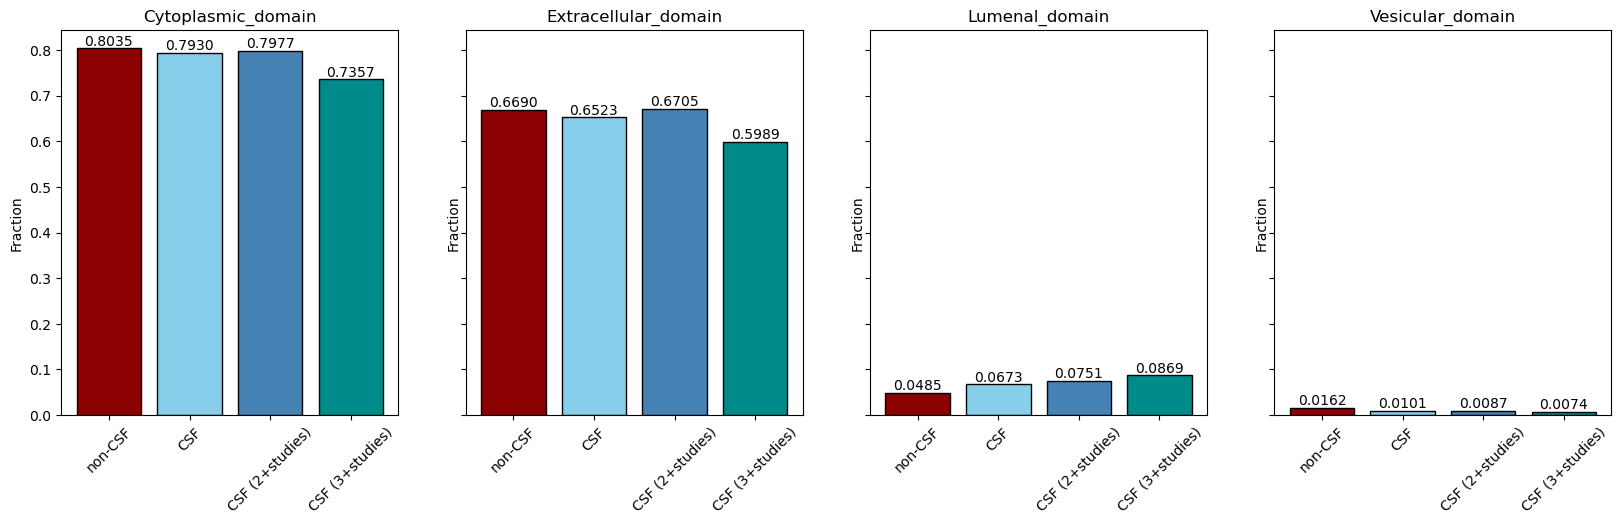

In [62]:
features = ["Cytoplasmic_domain", "Extracellular_domain", "Lumenal_domain", "Vesicular_domain"]

fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

for i in range(len(features)):
    bars = ax[i].bar(x=["non-CSF", "CSF", "CSF (2+studies)", "CSF (3+studies)"], height=get_percentages(df_list, features[i]),
        color=["darkred", "skyblue", "steelblue", "darkcyan"], edgecolor="black")
    ax[i].bar_label(bars, fmt="%.4f")
    ax[i].tick_params(axis="x", labelrotation=45)
    ax[i].set(ylabel="Fraction", title=features[i])

plt.show()

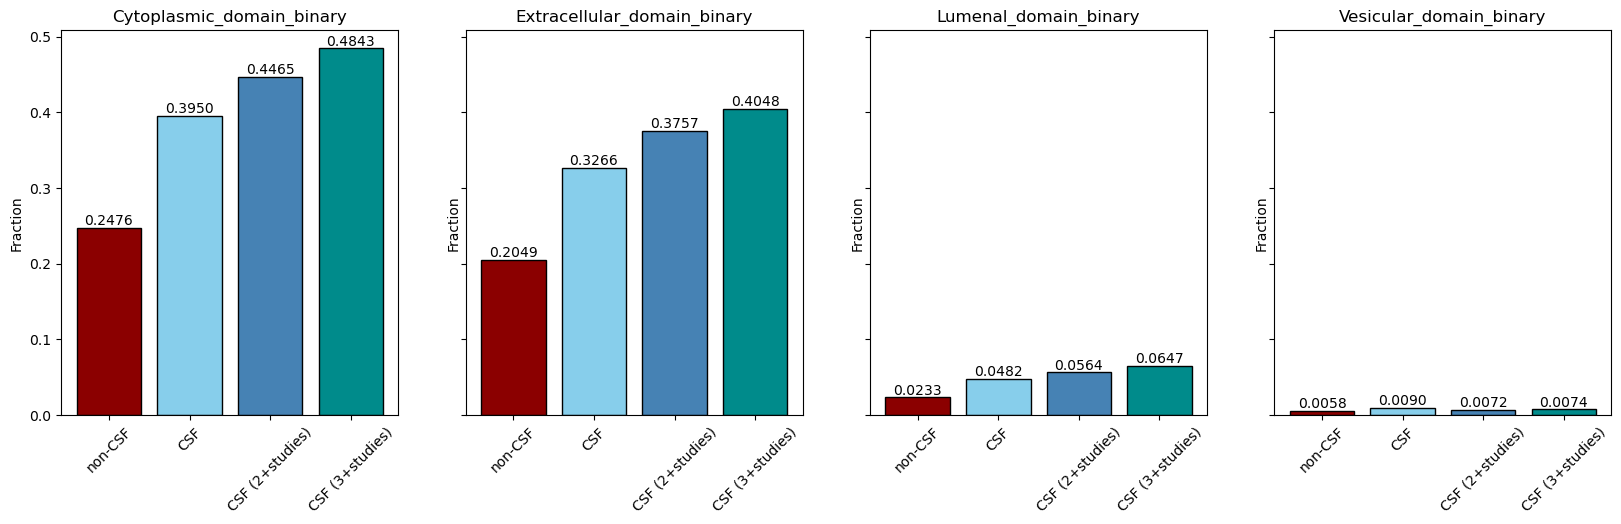

In [63]:
features = ["Cytoplasmic_domain_binary", "Extracellular_domain_binary", "Lumenal_domain_binary", "Vesicular_domain_binary"]

fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

for i in range(len(features)):
    bars = ax[i].bar(x=["non-CSF", "CSF", "CSF (2+studies)", "CSF (3+studies)"], height=get_percentages(df_list, features[i]),
        color=["darkred", "skyblue", "steelblue", "darkcyan"], edgecolor="black")
    ax[i].bar_label(bars, fmt="%.4f")
    ax[i].tick_params(axis="x", labelrotation=45)
    ax[i].set(ylabel="Fraction", title=features[i])

plt.show()

In [64]:
cytoplasmic_df = pd.DataFrame()

for i, data in enumerate(df_list):
    # add proportions of transmembrane region counts to dataframe
    top = pd.Series(data["Cytoplasmic_domain"].value_counts(normalize=True).sort_index(), name=names[i])
    cytoplasmic_df = pd.merge(cytoplasmic_df, top, left_index=True, right_index=True, how="outer")
cytoplasmic_df.reset_index(inplace=True)


extracellular_df = pd.DataFrame()

for i, data in enumerate(df_list):
    # add proportions of transmembrane region counts to dataframe
    top = pd.Series(data["Extracellular_domain"].value_counts(normalize=True).sort_index(), name=names[i])
    extracellular_df = pd.merge(extracellular_df, top, left_index=True, right_index=True, how="outer")
extracellular_df.reset_index(inplace=True)


lumenal_df = pd.DataFrame()

for i, data in enumerate(df_list):
    # add proportions of transmembrane region counts to dataframe
    top = pd.Series(data["Lumenal_domain"].value_counts(normalize=True).sort_index(), name=names[i])
    lumenal_df = pd.merge(lumenal_df, top, left_index=True, right_index=True, how="outer")
lumenal_df.reset_index(inplace=True)


vesicular_df = pd.DataFrame()

for i, data in enumerate(df_list):
    # add proportions of transmembrane region counts to dataframe
    top = pd.Series(data["Vesicular_domain"].value_counts(normalize=True).sort_index(), name=names[i])
    vesicular_df = pd.merge(vesicular_df, top, left_index=True, right_index=True, how="outer")
vesicular_df.reset_index(inplace=True)

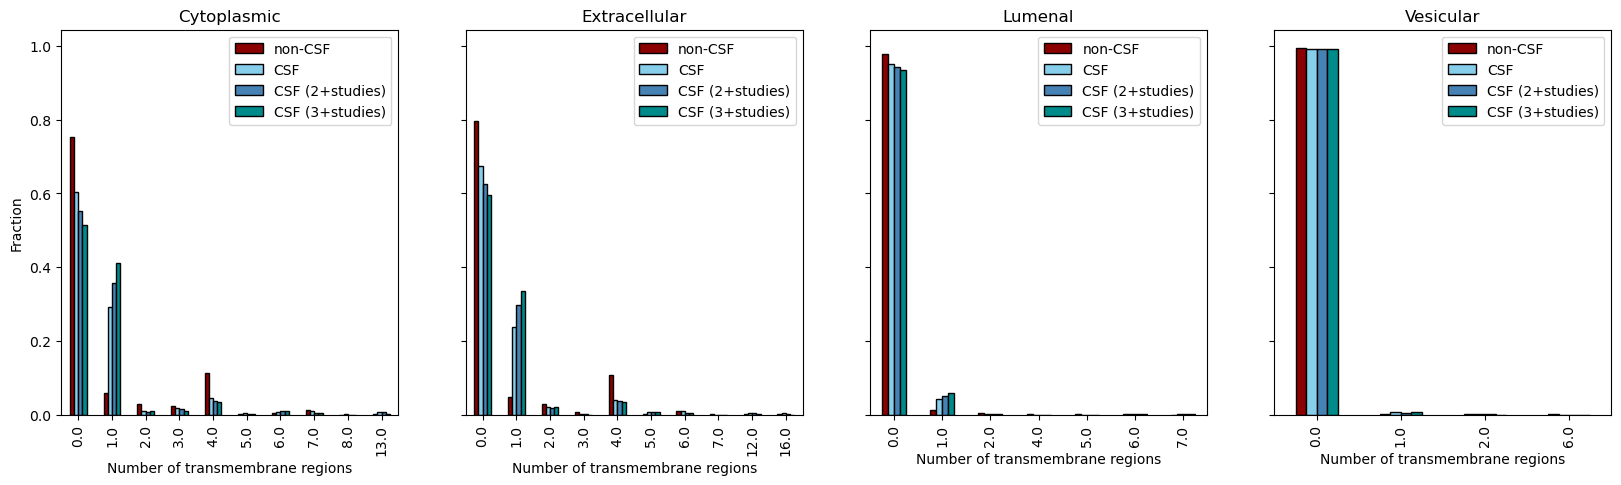

In [65]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

cytoplasmic_df.plot(x="index", y=["non-CSF", "CSF", "CSF (2+studies)", "CSF (3+studies)"], kind="bar",
          color=["darkred", "skyblue", "steelblue", "darkcyan"], edgecolor="black", ax=ax[0])
ax[0].set(xlabel="Number of transmembrane regions", ylabel="Fraction", 
    title="Cytoplasmic")

extracellular_df.plot(x="index", y=["non-CSF", "CSF", "CSF (2+studies)", "CSF (3+studies)"], kind="bar",
          color=["darkred", "skyblue", "steelblue", "darkcyan"], edgecolor="black", ax=ax[1])
ax[1].set(xlabel="Number of transmembrane regions", ylabel="Fraction", 
    title="Extracellular")

lumenal_df.plot(x="index", y=["non-CSF", "CSF", "CSF (2+studies)", "CSF (3+studies)"], kind="bar",
          color=["darkred", "skyblue", "steelblue", "darkcyan"], edgecolor="black", ax=ax[2])
ax[2].set(xlabel="Number of transmembrane regions", ylabel="Fraction", 
    title="Lumenal")

vesicular_df.plot(x="index", y=["non-CSF", "CSF", "CSF (2+studies)", "CSF (3+studies)"], kind="bar",
          color=["darkred", "skyblue", "steelblue", "darkcyan"], edgecolor="black", ax=ax[3])
ax[3].set(xlabel="Number of transmembrane regions", ylabel="Fraction", 
    title="Vesicular")

plt.show()   
fig.savefig(fig_path + "Bar_topological_domains_transmembrane.png", bbox_inches="tight")

### Ectodomain shedding annotations

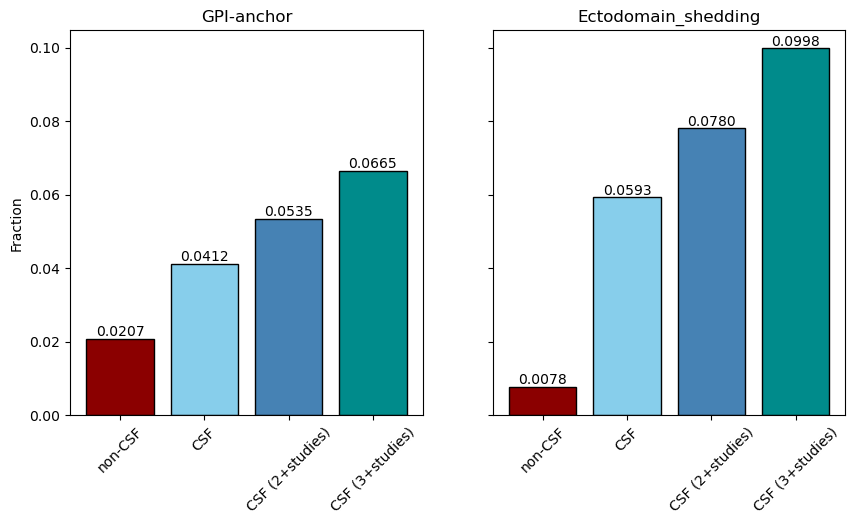

In [66]:
plot_percentages(["GPI-anchor", "Ectodomain_shedding"], "Bar_GPI-anchor_ectodomain.png")

In [67]:
pd.crosstab(df_features["Ectodomain_shedding"], df_features["PredHel"])

PredHel,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,14.0,15.0,17.0,19.0,20.0,21.0,35.0
Ectodomain_shedding,,,,,,,,,,,,,,,,,,,,
0,1536,368,92,37,97,29,51,147,17,15,14,15,35,4,1,4,5,1,2,1
1,26,37,3,0,1,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0


## Continuous features

In [68]:
def create_concatenated_df(feature):
    
    df_feature_list = []
    
    # subset for feature and add category column
    for i, df in enumerate(df_list):
        df_feature = df[[feature]]
        df_feature["Category"] = names[i]
        df_feature_list.append(df_feature)
    
    # concatenate results
    df_concatenated = pd.concat(df_feature_list)
        
    return df_concatenated


def plot_distribution(feature, file_name):
    """
    """
    # create concatneated dataframe
    df_concatenated = create_concatenated_df(feature)
    
    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    sns.violinplot(y=feature, x="Category", data=df_concatenated, palette=["darkred", "skyblue", "steelblue", "darkcyan"])
    ax.set(xlabel=None)
    ax.tick_params(axis="x", labelrotation=45)
    plt.show()
    
    fig.savefig(fig_path + file_name, bbox_inches="tight")
    
    return None

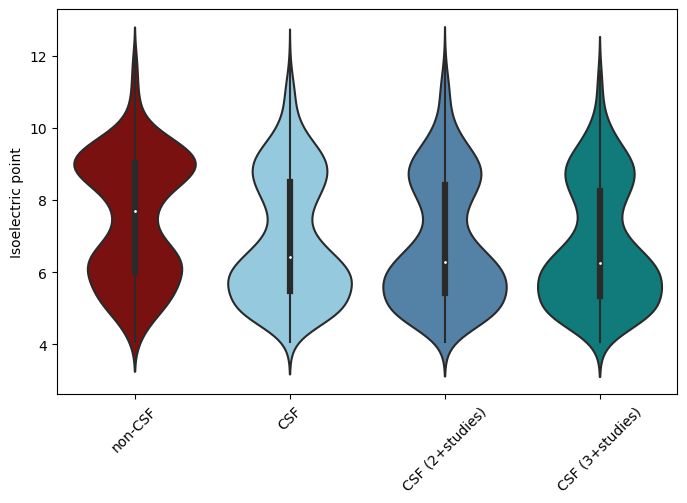

In [69]:
plot_distribution("Isoelectric point", "Violin_iP.png")

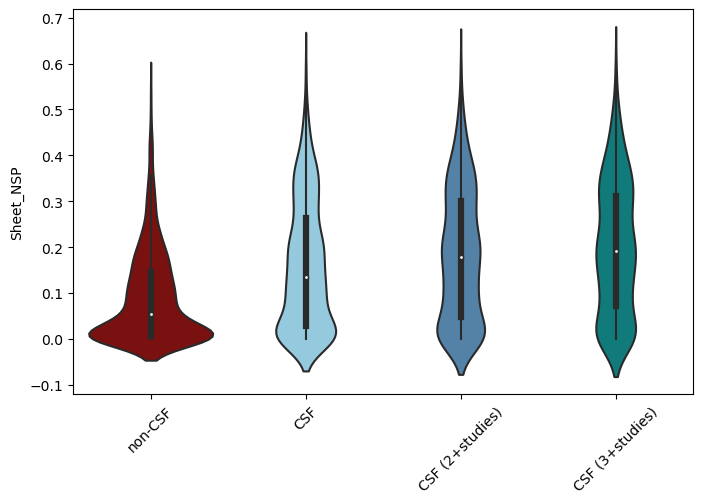

In [70]:
plot_distribution("Sheet_NSP", "Violin_Sheet_NSP.png")

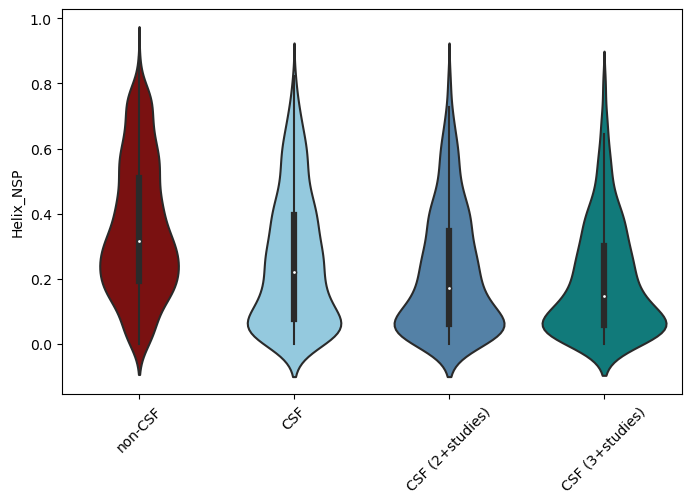

In [71]:
plot_distribution("Helix_NSP", "Violin_Helix_NSP.png")

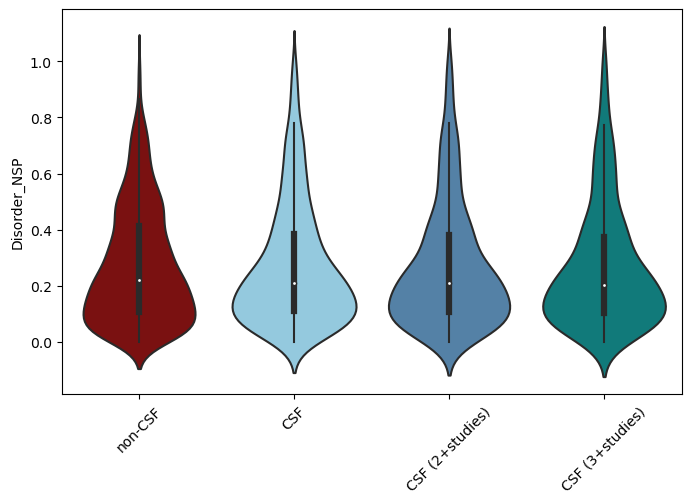

In [72]:
plot_distribution("Disorder_NSP", "Violin_Disorder_NSP.png")

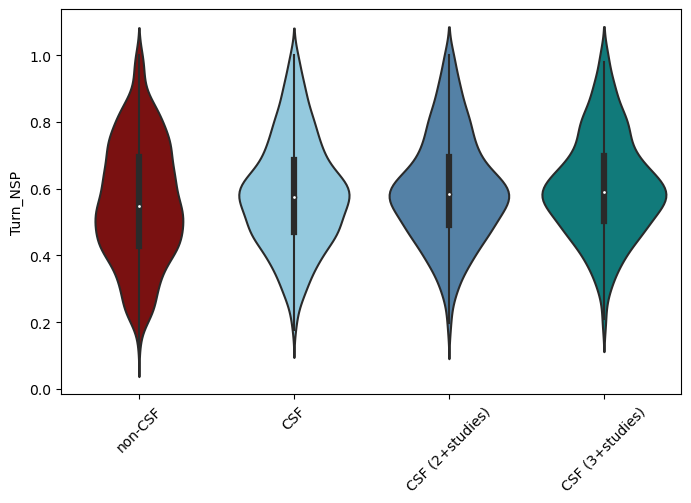

In [73]:
plot_distribution("Turn_NSP", "Violin_Turn_NSP.png")

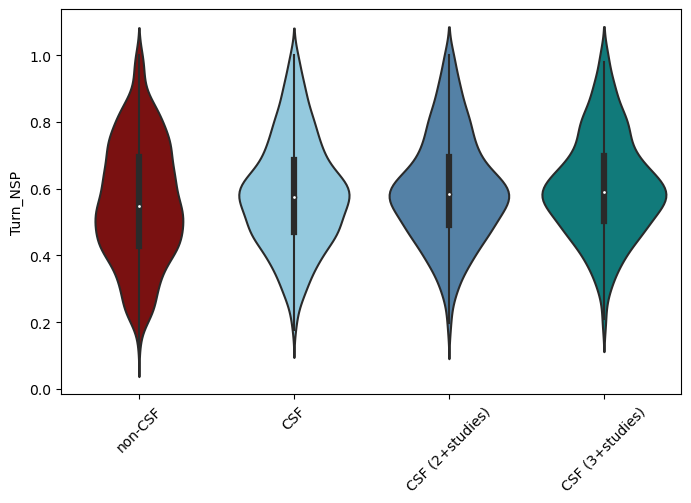

In [74]:
plot_distribution("Turn_NSP", "Violin_Turn_NSP.png")

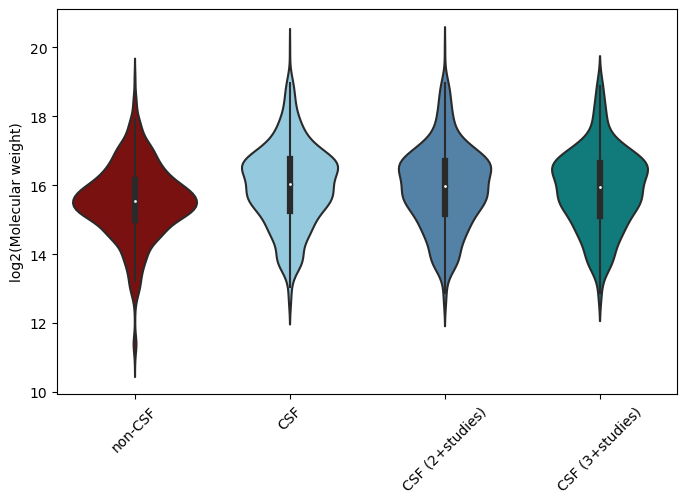

In [75]:
#### TO DO ####
# plot log2 of MW

plot_distribution("log2(Molecular weight)", "Violin_MW_log2.png")

In [76]:
print(np.min(CSF_1plus["log2(Molecular weight)"]))
print(np.min(non_CSF["log2(Molecular weight)"]))

12.5713391127728
10.947084809710125


# Figures for CSF Society Meeting 2022 abstract

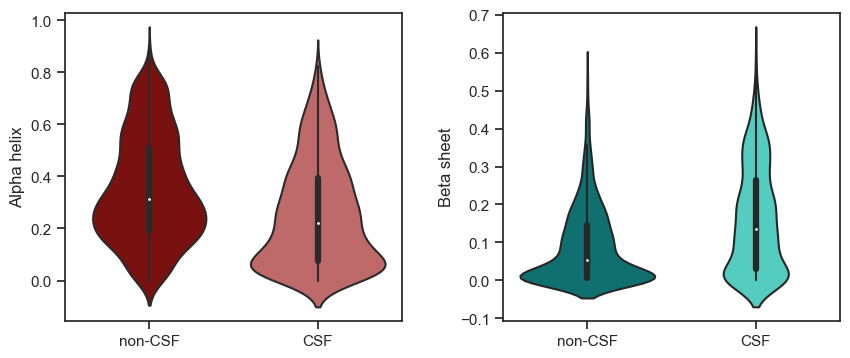

In [77]:
sns.set(style=("ticks"), font_scale=1)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
fig.subplots_adjust(wspace=0.3)#, hspace=None)

sns.violinplot(y="Helix_NSP",  x="CSF", data=df_features, ax=axes[0], palette=["darkred", "indianred"])
axes[0].set(xlabel=None, ylabel="Alpha helix", xticklabels=["non-CSF", "CSF"])
sns.violinplot(y="Sheet_NSP",  x="CSF", data=df_features, ax=axes[1], palette=["teal", "turquoise"])
axes[1].set(xlabel=None, ylabel="Beta sheet", xticklabels=["non-CSF", "CSF"])

plt.show()
fig.savefig(fig_path + "CSF_society_meeting_Figure2.png", bbox_inches="tight")

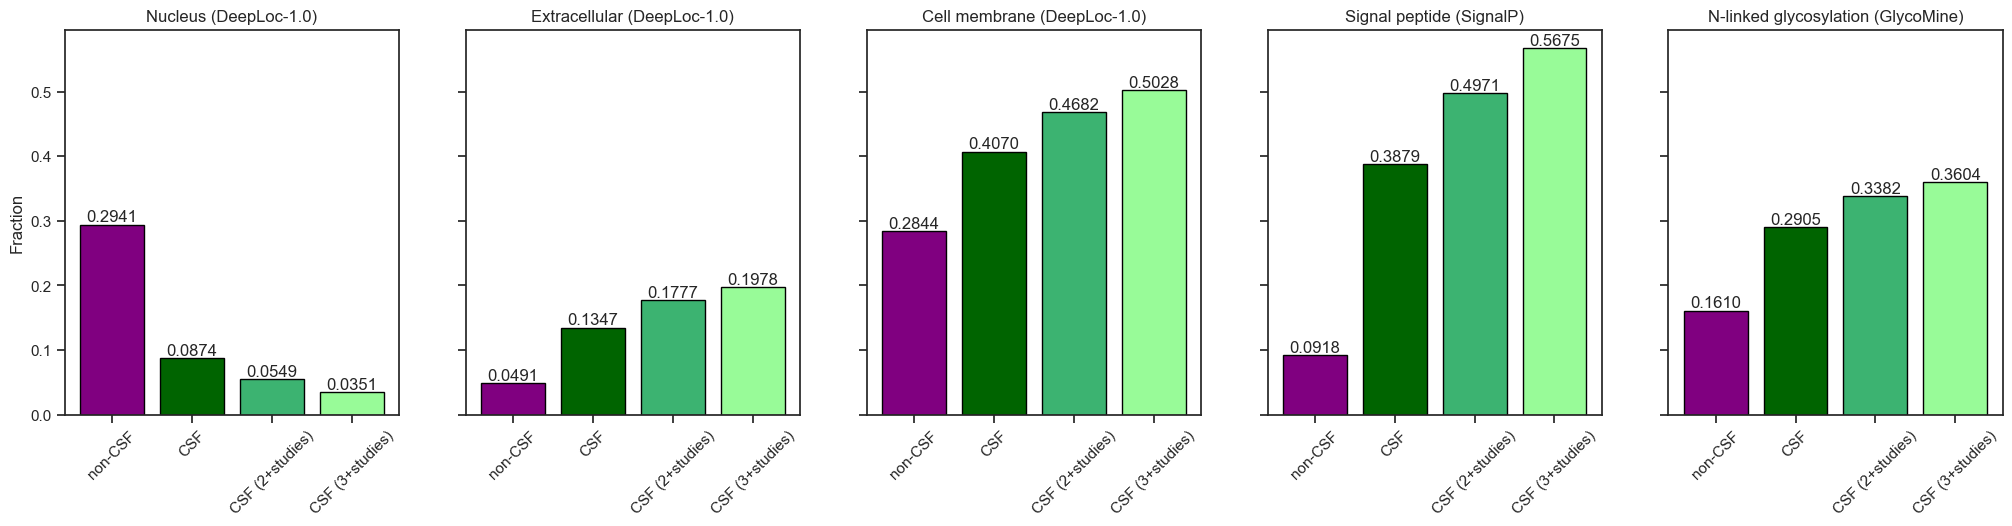

In [78]:
features = ["Nucleus", "Extracellular", "Cell_membrane", "Signal peptide", "GlycoMine_N"]
names_csm = ["Nucleus (DeepLoc-1.0)", "Extracellular (DeepLoc-1.0)", "Cell membrane (DeepLoc-1.0)","Signal peptide (SignalP)", 
            "N-linked glycosylation (GlycoMine)"]

fig, ax = plt.subplots(1, 5, figsize=(25, 5), sharey=True)

for i in range(len(features)):
    bars = ax[i].bar(x=["non-CSF", "CSF", "CSF (2+studies)", "CSF (3+studies)"], height=get_percentages(df_list, features[i]),
        color=["purple", "darkgreen", "mediumseagreen", "palegreen"], edgecolor="black")
    ax[i].bar_label(bars, fmt="%.4f")
    ax[i].tick_params(axis="x", labelrotation=45)
    if i == 0:
        ax[i].set(ylabel="Fraction", title=names_csm[i])
    else:
        ax[i].set(ylabel=None, title=names_csm[i])
        
plt.show()
fig.savefig(fig_path + "CSF_society_meeting_poster_A.png", bbox_inches="tight")

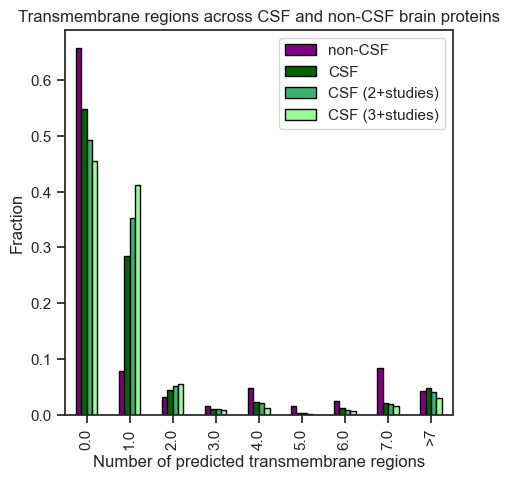

In [79]:
sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

tm_df.plot(x="index", y=["non-CSF", "CSF", "CSF (2+studies)", "CSF (3+studies)"], kind="bar",
          color=["purple", "darkgreen", "mediumseagreen", "palegreen"], edgecolor="black", ax=ax)
ax.set(xlabel="Number of predicted transmembrane regions", ylabel="Fraction", 
    title="Transmembrane regions across CSF and non-CSF brain proteins")

plt.show()   
fig.savefig(fig_path + "CSF_society_meeting_poster_B.png", bbox_inches="tight")